<a href="https://colab.research.google.com/github/lizjwh/groupIAI_5take2/blob/main/5%20Completely%20New%20Model/ConfusionMatrix_Densenet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install torchvision and kaggle
!pip install torchvision
!pip install kaggle
!pip install tqdm
!pip install colorama

In [4]:
#import  needed libraries and check the used gpu
import torch
from torch import nn, optim, tensor
from torchvision import transforms, models ,datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [3]:
! export KAGGLE_USERNAME="emmet454" && export KAGGLE_KEY="ee00fbc0728a71f5c5f712029e3ef004" && kaggle datasets download --force --unzip emilyburt/intro-to-ai

100% 4.06G/4.08G [00:58<00:00, 159MB/s]
100% 4.08G/4.08G [00:58<00:00, 74.9MB/s]


In [4]:
# Check whether we have a GPU.  Use it if we do.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)

Device: cpu


In [5]:
class SimplifiedModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimplifiedModel, self).__init__()

        # Load a pretrained DenseNet model
        densenet_model = models.densenet121(pretrained=True)

        # Use only the feature extractor part of DenseNet
        self.features = densenet_model.features

        # Modify the classifier part
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=0.3), #next test for this
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create an instance of the SimplifiedModel
model = SimplifiedModel(in_channels=3,num_classes=27)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
!git clone https://github.com/lizjwh/groupIAI_5take2
model.load_state_dict(torch.load('groupIAI_5take2/5 Completely New Model/Pretrained Densenet, 11 epochs with dropout.pth',map_location=device))
model.to(device)
model.eval()

fatal: destination path 'groupIAI_5take2' already exists and is not an empty directory.


SimplifiedModel(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [6]:
#These functions allow each folder to be combined
from torch.utils.data import ConcatDataset

def create_dataset(root_dir):
    """
    Creates an ImageFolder dataset from the specified root directory.
    """
    data_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    dataset = datasets.ImageFolder(root_dir, transform=data_transforms)
    return dataset

def combine_datasets(root_folders):
    """
    Combines datasets from multiple root folders into one dataset.
    """
    datasets = [create_dataset(folder) for folder in root_folders]
    combined_dataset = ConcatDataset(datasets)

    # Extract class-to-index mappings from individual datasets and merge them
    class_to_idx = {}
    for dataset in datasets:
        class_to_idx.update(dataset.class_to_idx)

    return combined_dataset, class_to_idx

def main():
  #choose which folders to include in test here
    root_folders = ['/content/Dataset/Restricted mobility/Left hand',
                    '/content/Dataset/Restricted mobility/Right hand',
                    '/content/Dataset/Full Mobility/Left hand',
                    '/content/Dataset/Full Mobility/Right hand']

    combined_dataset, combined_dataset.class_to_idx = combine_datasets(root_folders)

    print(f"Class to index mapping: {combined_dataset.class_to_idx}")
    return combined_dataset

combined_dataset = main()


#define the transform for the dataset
#test_transforms = transforms.Compose([transforms.Resize((224,224)),
#                                      transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406],
 #                                                           [0.229, 0.224, 0.225])])

#transform the data
#test_data = datasets.ImageFolder(path,test_transforms)
#path = '/content/Dataset/Restricted mobility/Right hand'
#test_data.append(datasets.ImageFolder(path,test_transforms))
#path = '/content/Dataset/Full Mobility/Left hand'
#test_data.append(datasets.ImageFolder(path,test_transforms))
#path = '/content/Dataset/Full Mobility/Right hand'
#test_data.append(datasets.ImageFolder(path,test_transforms))
#print(f"class to index mapping: {test_data.class_to_idx}")

# #load some of the test data
# testloader = torch.utils.data.DataLoader(combined_dataset, batch_size=50, shuffle=True)
# images, labels = next(iter(testloader))
# print(labels)
# #print(images.size())

Class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'Space': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


#Confusion matrix

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [11]:
def test(classes, test_loader):
    pred = []
    true = []

    # Iterate through all batches in the test_loader
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass through the model
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Convert predicted and true labels to class names
        try:
            pred.extend([classes[label.item()] for label in predicted])
            true.extend([classes[label.item()] for label in labels])
            print(pred, true)
        except KeyError as e:
            print(f"Error: {e} not found in classes dictionary.")
            print(f"Problematic labels: {predicted}, {labels}")

    return pred, true

#create test loader
batchsize = 128
test_loader = torch.utils.data.DataLoader(dataset=combined_dataset,
                                          batch_size=batchsize,
                                          shuffle=True)

#invert class_to_idx keys to values and vice versa.
classes = combined_dataset.class_to_idx
classes = {value: key for key, value in classes.items()}

pred, true = test(classes, test_loader)
print(pred, true)

KeyboardInterrupt: 

64
{'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D', 'E': 'E', 'F': 'F', 'G': 'G', 'H': 'H', 'I': 'I', 'J': 'J', 'K': 'K', 'L': 'L', 'M': 'M', 'N': 'N', 'O': 'O', 'P': 'P', 'Q': 'Q', 'R': 'R', 'S': 'S', 'Space': 'Space', 'T': 'T', 'U': 'U', 'V': 'V', 'W': 'W', 'X': 'X', 'Y': 'Y', 'Z': 'Z'}


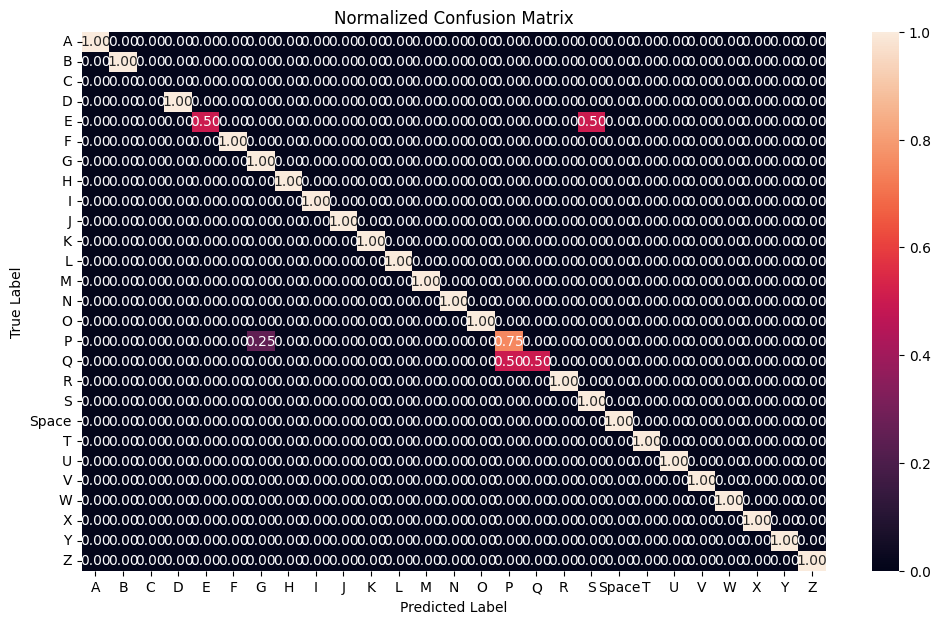

In [10]:
def plotConfusionMatrix(pred, true, classes):
    # Change classes dictionary to this format {'A': 'A', 'B': 'B', 'C': 'C'...} for labelling the axis later
    classes = {value: value for key, value in classes.items()}

    # Convert class_to_idx dictionary to list of class names
    unique_classes = sorted(set(true + pred))

    # Ensure that all classes are included, even if they are not present in the batch of data
    all_classes = sorted(set(classes.values()))

    # Create confusion matrix
    cf_matrix = confusion_matrix(
        [classes[label] for label in true],
        [classes[label] for label in pred],
        labels=all_classes
    )

    # Create DataFrame using class names for index and columns
    df_cm = pd.DataFrame(cf_matrix, index=all_classes, columns=all_classes)

    # Normalize the confusion matrix by row (i.e., by the number of true instances for each class)
    df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)

    # Add 0s to empty cells
    df_cm = df_cm.fillna(0.00)
    #print(df_cm)

    plt.figure(figsize=(12, 7))
    print(classes)
    sn.heatmap(df_cm, annot=True, fmt=".2f")  # Adjust fmt as needed for displaying float values
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()


# #To run this cell independently you need these lines and some sample predictions
classes = combined_dataset.class_to_idx
classes = {value: key for key, value in classes.items()}
#pred = ['S', 'A', 'X', 'R', 'Space', 'G', 'Z', 'T', 'O', 'S', 'X', 'S', 'H', 'B', 'Q', 'W', 'W', 'M', 'A', 'R', 'J', 'P', 'T', 'K', 'O', 'M', 'F', 'G', 'Space', 'Z', 'O', 'W', 'I', 'F', 'P', 'Y', 'F', 'T', 'W', 'E', 'N', 'N', 'R', 'L', 'U', 'G', 'A', 'D', 'T', 'G', 'O', 'P', 'L', 'K', 'R', 'V', 'A', 'D', 'V', 'N', 'P', 'V', 'W', 'A']
#true = ['S', 'A', 'X', 'R', 'Space', 'G', 'Z', 'T', 'O', 'E', 'X', 'S', 'H', 'B', 'Q', 'W', 'W', 'M', 'A', 'R', 'J', 'P', 'T', 'K', 'O', 'M', 'F', 'P', 'Space', 'Z', 'O', 'W', 'I', 'F', 'P', 'Y', 'F', 'T', 'W', 'E', 'N', 'N', 'R', 'L', 'U', 'G', 'A', 'D', 'T', 'G', 'O', 'Q', 'L', 'K', 'R', 'V', 'A', 'D', 'V', 'N', 'P', 'V', 'W', 'A']
print(len(pred))
# Call the function to plot the confusion matrix
plotConfusionMatrix(pred, true, classes)